<a href="https://colab.research.google.com/github/Rimlee23/UNIFIED-TRANSFER-LEARNING-SCHEME-FOR-DETECTING-DEFECTS-FROM-BOTH-THERMAL-AND-RGB-IMAGES/blob/rimlee/Mat_file_Thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models

import os
import torch.optim as optim
import torch.nn.functional as F
import scipy
from skimage.transform import rotate
from os.path import join
from struct import unpack
import numpy as np
import time

import codecs

In [33]:
batch_size = 1
epochs = 30
channel_num=1810 # each infrared video has 1810 frames
crop_h = 128
crop_w = 128
learning_rate = 0.0001

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device is {device}')


if device == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')
    use_cuda = True
else:
    use_cuda = False
kwargs = {'num_workers': 0,
          'pin_memory': True} if use_cuda else {}

Device is cpu


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
directory = "/content/drive/My Drive/PVC-Infrared dataset"

In [6]:
from scipy import io
def make_dataset(img_filename_list, mask_filename_list, root):
    # build the dataset
    imgs = []
    masks = []

    for img_filename in img_filename_list:
        print(img_filename)
        mat_data = io.loadmat(join(root, img_filename))
        p = np.float32(mat_data["imageArray"])
        imgs.append(p)
    return imgs, mask_filename_list

In [34]:
def getCroprange(im_w, im_h, h, w):
    # getting croprange
    min_w = random.randint(0, im_w - w)
    min_h = random.randint(0, im_h - h)
    return min_w, min_h


class crop_clip():
    # crop function
    # crop_clip.image for original training data,crop_clip.mask for corresponding mask(ground truth)
    def __init__(self, clip, h, w, min_h, min_w):
        self.clip = clip
        self.h = h
        self.w = w
        self.min_h = min_h
        self.min_w = min_w
        self.clip = clip

    def image(self):
        cropped = self.clip[self.min_h:self.min_h + self.h, self.min_w:self.min_w + self.w, :]
        return cropped

    def mask(self):
        cropped = self.clip.crop((self.min_w, self.min_h, self.min_w + self.w, self.min_h + self.h))
        return cropped


class RandomRotation():
    # rotation
    def __init__(self, clip, angle):
        self.clip = clip
        self.angle = angle

    def image(self):
        h, w, c = self.clip.shape
        rotated = np.zeros((h, w, c), dtype=np.float32)
        for i in range(c):
            # clip[:,:,i] = scipy.misc.imrotate(clip[:,:,i], angle)  #does not work..
            p = Image.fromarray(self.clip[:, :, i])
            p = p.rotate(self.angle)
            rotated[:, :, i] = np.array(p)
        return rotated

    def mask(self):
        rotated = self.clip.rotate(self.angle)
        return rotated

In [35]:
import random
class Data_set():
    def __init__(self, imgs, masks, root, crop_h, crop_w, ctype):
        self.imgs = imgs
        self.masks = masks
        self.type = ctype
        self.root = root
        self.crop_w = crop_w
        self.crop_h = crop_h
        random.seed(1)
        self.random_func = random
    def __len__(self):
        return len(self.imgs)

    def normalize(self, img):
        # input is torch tensor
        eps = 1e-10
        mean_value = torch.mean(img)
        std_value = torch.std(img)
        normed_img = (img - mean_value) / max(eps, std_value)
        return normed_img

    def transform(self, imgs, masks):
        image = imgs[:,:,:]
        mask = masks

        # rotate
        angle = self.random_func.uniform(0, 90)
        random_rotation_image = RandomRotation(image, angle)
        roteted_image = random_rotation_image.image()
        random_rotation_mask = RandomRotation(mask, angle)
        roteted_mask = random_rotation_mask.mask()

        ##crop
        im_h, im_w, im_c = imgs.shape
        min_w = self.random_func.randint(0, im_w - self.crop_w)
        min_h = self.random_func.randint(0, im_h - self.crop_h)
        crop_clip_image_obj = crop_clip(roteted_image, self.crop_h, self.crop_w, min_h, min_w)
        crop_clip_mask_obj = crop_clip(roteted_mask, self.crop_h, self.crop_w, min_h, min_w)
        image = crop_clip_image_obj.image()  ##normal case
        im_h1, im_w1, im_c1 = image.shape
        mask = crop_clip_mask_obj.mask()

        left_right_flip_rand_num =  self.random_func.random()
        if left_right_flip_rand_num > 0.5:
            image = np.fliplr(image)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        up_down_flip_rand_num =  self.random_func.random()
        if up_down_flip_rand_num > 0.5:
            image = np.flipud(image)
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        image = torch.from_numpy(image.copy())
        image = image.permute(2, 0, 1)
        image = self.normalize(image)
        mask = transforms.ToTensor()(mask)
        #print('max mask:')
        #print(torch.max(mask))
        return image, mask


    def __getitem__(self, index):
        img_x, maskpath = self.imgs[index], self.masks[index]
        mask_x = Image.open(join(self.root, maskpath))
        mask_x_np = np.array(mask_x)
        import skimage.io as im
        mask_x_sk = im.imread(join(self.root, maskpath))
        img_x, mask_x = self.transform(img_x, mask_x)
        return img_x, mask_x

In [9]:
def read_text_file_list(filepath):
    content = []
    with codecs.open(filepath, encoding='utf-8') as f:
        for line in f:
            content.append(line.strip())
    return content

data_splitting_folder = "/content/drive/My Drive/PVC-Infrared dataset/"
root = data_splitting_folder
train_datalist_filename = "train_data.txt"
val_datalist_filename = "val_data.txt"
train_labellist_filename = "train_label.txt"
val_labellist_filename = "val_label.txt"

train_img_file_list = read_text_file_list(join(data_splitting_folder, train_datalist_filename))
train_gt_mask_file_list = read_text_file_list(join(data_splitting_folder, train_labellist_filename))
val_img_file_list = read_text_file_list(join(data_splitting_folder, val_datalist_filename))
val_gt_mask_file_list = read_text_file_list(join(data_splitting_folder, val_labellist_filename))

train_imgs, train_masks = make_dataset(train_img_file_list, train_gt_mask_file_list, data_splitting_folder)
train_dataset = Data_set(train_imgs, train_masks, data_splitting_folder, crop_h, crop_w, 'train')
train_data_loader = DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               **kwargs)
val_imgs, val_masks = make_dataset(val_img_file_list, val_gt_mask_file_list, data_splitting_folder)
val_dataset = Data_set(val_imgs, val_masks, data_splitting_folder, crop_h, crop_w, 'validate')
val_data_loader = DataLoader(dataset=val_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)

Z_003.mat
Z_005.mat
Z_006.mat
Z_007.mat
Z_010.mat
Z_011.mat
Z_012.mat
Z_014.mat
Z_015.mat
Z_016.mat
Z_018.mat
Z_019.mat
Z_020.mat
Z_002.mat
Z_008.mat
Z_017.mat


In [36]:
class one_step_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(one_step_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            #nn.Conv2d(out_ch, out_ch, 3, padding=1),
            #nn.BatchNorm2d(out_ch),
            #nn.ReLU(inplace=True),
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        base_filter_num = 64
        self.conv_down_1 = one_step_conv(in_ch, base_filter_num)
        self.pool1 = nn.MaxPool2d(2)
        self.conv_down_2 = one_step_conv(base_filter_num, base_filter_num*2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv_down_3 = one_step_conv(base_filter_num*2, base_filter_num*4)
        self.pool3 = nn.MaxPool2d(2)
        self.conv_down_4 = one_step_conv(base_filter_num*4, base_filter_num*8)
        self.pool4 = nn.MaxPool2d(2)
        self.conv_bottom = one_step_conv(base_filter_num*8, base_filter_num*16)

        self.upsample_1 = nn.ConvTranspose2d(base_filter_num*16, base_filter_num*8, 2, stride=2)
        self.conv_up_1 = one_step_conv(base_filter_num*16, base_filter_num*8)
        self.upsample_2 = nn.ConvTranspose2d(base_filter_num*8, base_filter_num*4, 2, stride=2)
        self.conv_up_2 = one_step_conv(base_filter_num*8, base_filter_num*4)
        self.upsample_3 = nn.ConvTranspose2d(base_filter_num*4, base_filter_num*2, 2, stride=2)
        self.conv_up_3 = one_step_conv(base_filter_num*4, base_filter_num*2)
        self.upsample_4 = nn.ConvTranspose2d(base_filter_num*2, base_filter_num, 2, stride=2)
        self.conv_up_4 = one_step_conv(base_filter_num*2, base_filter_num)
        self.conv_out = nn.Conv2d(base_filter_num, out_ch, 1)

    def forward(self, x):
        ###down########
        down_1 = self.conv_down_1(x)
        pool_1 = self.pool1(down_1)
        down_2 = self.conv_down_2(pool_1)
        pool_2 = self.pool2(down_2)
        down_3 = self.conv_down_3(pool_2)
        pool_3 = self.pool3(down_3)
        down_4 = self.conv_down_4(pool_3)
        pool_4 = self.pool3(down_4)
        bottom = self.conv_bottom(pool_4)

        up_1 = self.upsample_1(bottom)
        merge1 = torch.cat([up_1, down_4], dim=1)
        up_1_out = self.conv_up_1(merge1)

        up_2 = self.upsample_2(up_1_out)
        merge2 = torch.cat([up_2, down_3], dim=1)
        up_2_out = self.conv_up_2(merge2)

        up_3 = self.upsample_3(up_2_out)
        merge3 = torch.cat([up_3, down_2], dim=1)
        up_3_out = self.conv_up_3(merge3)

        up_4 = self.upsample_4(up_3_out)
        merge4 = torch.cat([up_4, down_1], dim=1)
        up_3_out = self.conv_up_4(merge4)

        end_out = self.conv_out(up_3_out)
        out = nn.Sigmoid()(end_out)

        return out

In [37]:
model = Unet(in_ch=channel_num, out_ch=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = torch.nn.BCELoss()

In [38]:
import sklearn.metrics as metrics # for evaluation

def validate(model, loss_fn, dataloader, device):
    step = 0
    acc_sum = 0
    loss_sum = 0
    with torch.no_grad():
        for i, (vali_batch, vali_mask) in enumerate(dataloader):
            step += 1
            vali_batch, vali_mask = vali_batch.to(device), vali_mask.to(device, dtype=torch.long)
            vali_mask = vali_mask.float()
            prediction = model(vali_batch)
            prediction = torch.squeeze(prediction)
            vali_mask = torch.squeeze(vali_mask)
            val_loss = loss_fn(prediction, vali_mask)
            loss_sum += val_loss.data.item()

            threshold_using = 0.5 # for binarization
            binary = prediction >= threshold_using
            _accuracy = metrics.accuracy_score(vali_mask.cpu().view(-1).detach().numpy(), binary.cpu().view(-1).detach().numpy())
            acc_sum += _accuracy


    loss = loss_sum / len(dataloader)
    acc = acc_sum / len(dataloader)

    return loss, acc

Epoch 0 / 30
epoch: 0, accuracy: 0.8675208458533654, loss: 0.612178637431218
 min val_loss
inf
Epoch 1 / 30
epoch: 1, accuracy: 0.9283635066105769, loss: 0.5433260821379148
 min val_loss
0.5841997861862183
Epoch 2 / 30
epoch: 2, accuracy: 0.94378662109375, loss: 0.5097370376953712
 min val_loss
0.5081866582234701
Epoch 3 / 30
epoch: 3, accuracy: 0.961181640625, loss: 0.4630340108504662
 min val_loss
0.49348466595013935
Epoch 4 / 30
epoch: 4, accuracy: 0.9655902569110577, loss: 0.4291695150045248
 min val_loss
0.46045006314913434
Epoch 5 / 30
epoch: 5, accuracy: 0.9614680363581731, loss: 0.41570557539279646


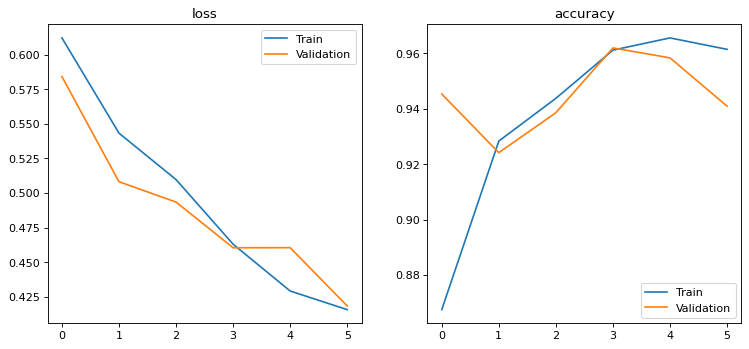

 min val_loss
0.46045006314913434
Epoch 6 / 30
epoch: 6, accuracy: 0.9667452298677884, loss: 0.3817889713324033
 min val_loss
0.41834279894828796
Epoch 7 / 30
epoch: 7, accuracy: 0.9642005333533654, loss: 0.38713611318514896
 min val_loss
0.37073348959287006
Epoch 8 / 30
epoch: 8, accuracy: 0.9591815655048077, loss: 0.37101044333898103
 min val_loss
0.37073348959287006
Epoch 9 / 30
epoch: 9, accuracy: 0.9524348332331731, loss: 0.3664629551080557
 min val_loss
0.3706757227579753
Epoch 10 / 30
epoch: 10, accuracy: 0.9707782451923077, loss: 0.3341183983362638


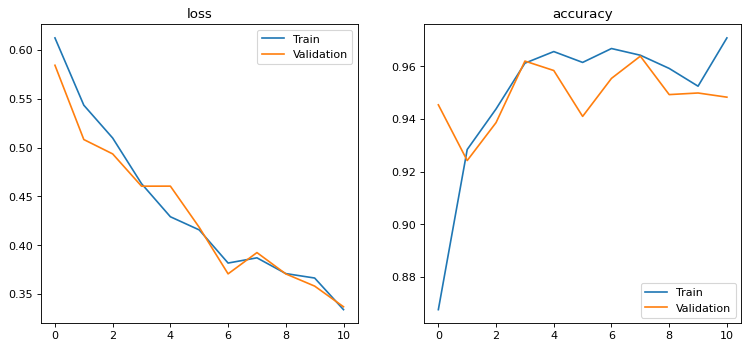

 min val_loss
0.3582053283850352
Epoch 11 / 30
epoch: 11, accuracy: 0.9664165790264423, loss: 0.3241651149896475
 min val_loss
0.33705203731854755
Epoch 12 / 30
epoch: 12, accuracy: 0.9634258563701923, loss: 0.3217009695676657
 min val_loss
0.3322818875312805
Epoch 13 / 30
epoch: 13, accuracy: 0.9702852689302884, loss: 0.3027355946027316
 min val_loss
0.3048493266105652
Epoch 14 / 30
epoch: 14, accuracy: 0.9683790940504807, loss: 0.29305323041402376
 min val_loss
0.2938147187232971
Epoch 15 / 30
epoch: 15, accuracy: 0.9740459735576923, loss: 0.27090683808693516


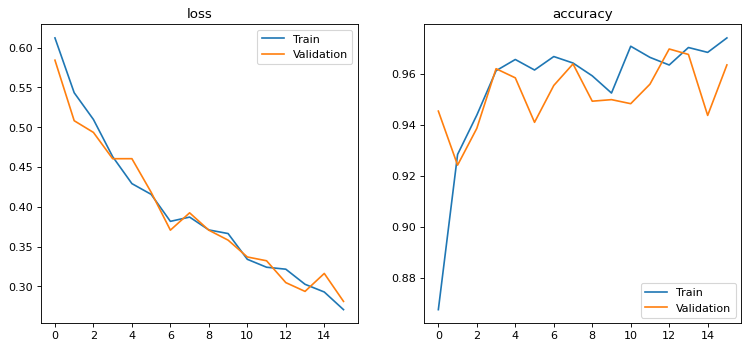

 min val_loss
0.2938147187232971
Epoch 16 / 30
epoch: 16, accuracy: 0.9730553260216346, loss: 0.271255591740975
 min val_loss
0.2812536060810089
Epoch 17 / 30
epoch: 17, accuracy: 0.9724543644831731, loss: 0.26723233323830825
 min val_loss
0.2812536060810089
Epoch 18 / 30
epoch: 18, accuracy: 0.977783203125, loss: 0.25687492237641263
 min val_loss
0.27858742078145343
Epoch 19 / 30
epoch: 19, accuracy: 0.9832528921274039, loss: 0.24256583245900962
 min val_loss
0.26563267906506854
Epoch 20 / 30
epoch: 20, accuracy: 0.9766141451322116, loss: 0.24151838972018316


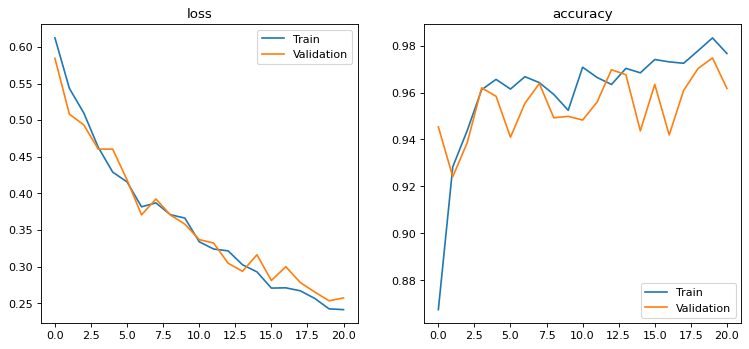

 min val_loss
0.2536218961079915
Epoch 21 / 30
epoch: 21, accuracy: 0.9746985802283654, loss: 0.2388534305187372
 min val_loss
0.2536218961079915
Epoch 22 / 30
epoch: 22, accuracy: 0.9727642352764423, loss: 0.23235418934088486
 min val_loss
0.2479768842458725
Epoch 23 / 30
epoch: 23, accuracy: 0.9768301156850961, loss: 0.22665372949380141
 min val_loss
0.22794896364212036
Epoch 24 / 30
epoch: 24, accuracy: 0.9813467172475961, loss: 0.21852875328980959
 min val_loss
0.22794896364212036
Epoch 25 / 30
epoch: 25, accuracy: 0.9792386568509616, loss: 0.21515811292024759


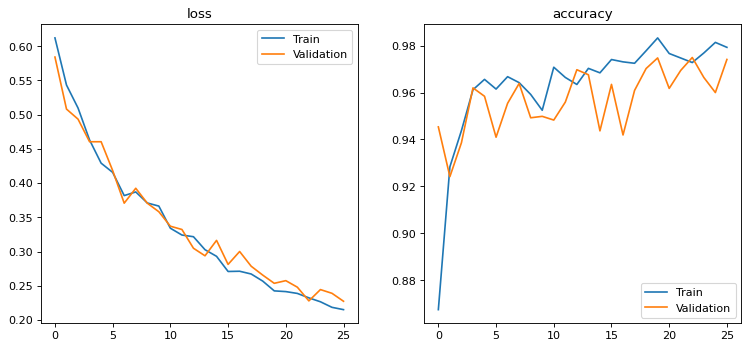

 min val_loss
0.22794896364212036
Epoch 26 / 30
epoch: 26, accuracy: 0.9817551832932693, loss: 0.20572747404758746
 min val_loss
0.2274023840824763
Epoch 27 / 30
epoch: 27, accuracy: 0.9852060171274039, loss: 0.19530473076380217
 min val_loss
0.2274023840824763
Epoch 28 / 30
epoch: 28, accuracy: 0.9698533278245193, loss: 0.2098874575816668
 min val_loss
0.20875757932662964
Epoch 29 / 30
epoch: 29, accuracy: 0.9789804311899039, loss: 0.18818246515897605
 min val_loss
0.2011522650718689


In [39]:
from math import remainder
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_loss = []
epoch_val_accuracy = []
min_val_loss = float('inf')

for epoch in range(epochs):
    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))

    # Set variables
    #correct = 0
    #overlap = 0
    #union = 0
    _len = 0
    loss_sum = 0
    accuracy_sum = 0
    count = 0

    # Loop over the batches
    for index, (train_batch, mask) in enumerate(train_data_loader):
        #print(f'\tBatch {index}')

        if device is not None:
            train_batch = train_batch.to(device)
            mask = mask.to(device)

        # Call the model (image to mask)
        prediction = model(train_batch)

        # Compute the loss

        mask = torch.squeeze(mask.to(torch.float32))
        prediction= torch.squeeze(prediction.to(torch.float32))
        Loss = loss(prediction, mask)

        # Do PyTorch stuff
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        threshold_using = 0.5
        binary = prediction >= threshold_using
        current_accuracy = metrics.accuracy_score(mask.cpu().view(-1).detach().numpy(), binary.cpu().view(-1).detach().numpy())
        accuracy_sum = accuracy_sum + current_accuracy
        loss_sum = loss_sum+Loss.data.item()
        count = count+1


    train_loss = loss_sum/count
    train_accuracy = accuracy_sum/count
    string = "epoch: {}, accuracy: {}, loss: {}".format(epoch, train_accuracy, train_loss)
    print(string)
    val_loss, val_accuray = validate(model, loss, val_data_loader, device)

    epoch_train_loss.append(train_loss)
    epoch_train_accuracy.append(train_accuracy)

    epoch_val_loss.append(val_loss)
    epoch_val_accuracy.append(val_accuray)

    if len(epoch_train_loss) > 0 and remainder(epoch, 5) == 0 and epoch > 0:
        plt.figure(figsize=(10, 5), dpi=80)
        plt.subplot(1,2,1)
        plt.title('loss')
        plt.plot(epoch_train_loss)
        plt.plot(epoch_val_loss)
        plt.legend(['Train', 'Validation'], loc='upper right')
        #plt.ylim(0, 0.1)
        plt.subplot(1,2,2)
        plt.title('accuracy')
        plt.plot(epoch_train_accuracy)
        plt.plot(epoch_val_accuracy)
        plt.legend(['Train', 'Validation'], loc='lower right')
        #plt.ylim(0.95, 1)
        plt.tight_layout(pad=3.0)
        plt.show()
    print(' min val_loss')
    #print(val_loss)
    print(min_val_loss)
    if min_val_loss > val_loss: # update the model with best performance
        min_val_loss = val_loss
        best_model = model
        best_epoch = epoch

    if remainder(epoch, 10) == 0: # saved the best model every 10 epochs
        model_save_path_best= join('/content/drive/My Drive/PVC-Infrared dataset/working/', 'best_model' + '.pth')
        torch.save(model, model_save_path_best)

In [40]:
import skimage.color as color
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, jaccard_score
import cv2
import skimage.io as im

def evaluate(measurement_name, test_label_path, data_path, model_path):

    threshold_using = 0.5
    newsize = (320, 256)

    device = torch.device("cpu")

    model = torch.load(model_path,map_location='cpu')
    model.to(device)
    #model.eval()
    #
    mat_data = io.loadmat(data_path)
    data = np.float32(mat_data["imageArray"])

    imge = torch.from_numpy(data.copy())
    imge = imge.permute(2, 0, 1)
    input = torch.zeros(1, imge.size(0), imge.size(1), imge.size(2))
    input[0] = imge

    # normalization
    eps = 1e-10
    mean_value = torch.mean(input)
    std_value = torch.std(input)
    input = (input - mean_value) / max(eps, std_value)
    #""

    with torch.no_grad():
        output = model(input)
    pre = torch.reshape(output, (imge.size(1), imge.size(2)))
    pre = torch.reshape(pre, (1, imge.size(1), imge.size(2))).float()
    np_image = np.asarray(torch.squeeze(pre))

    binary = np_image > threshold_using

    np_image[np_image > threshold_using] = 255
    np_image[np_image <= threshold_using] = 0

    test_label_np = im.imread(test_label_path)
    plt.figure(figsize=(10, 5), dpi=80)
    plt.subplot(1,2,1)
    plt.title('predicted mask ')
    im.imshow(np_image)
    plt.subplot(1,2,2)
    plt.title('groundtruth mask')
    im.imshow(test_label_np)
    plt.show()

    ## evaluation
    test_label = torch.from_numpy(test_label_np)
    test_label_1d = (test_label.view(test_label.shape[0]*test_label.shape[1])).type('torch.FloatTensor')
    test_label_1d = test_label_1d/255
    binary_torch = torch.from_numpy(binary.astype(int))

    binary_torch_numpy255 = binary_torch.numpy().astype(np.uint8)*255
    test_label_numpy = test_label.numpy()

    binary_torch_1d = binary_torch.reshape(binary_torch.shape[0]*binary_torch.shape[1])
    accuracy = accuracy_score(test_label_1d, binary_torch_1d)
    recall = recall_score(test_label_1d, binary_torch_1d)
    precision = precision_score(test_label_1d, binary_torch_1d)
    f_score = f1_score(test_label_1d, binary_torch_1d)
    iou = jaccard_score(test_label_1d, binary_torch_1d)

    print("measurement " + measurement_name)
    print(
        "results of 2 class classification:\n"
        "threshold:{:.3f},\n"
        "Accuracy:({:.3f}%),\n "
        "Recall:({:.3f}%),\n"
        "Precision:({:.3f}%),\n "
        "F score: ({:.3f}%)\n"
        "iou: ({:.3f}%)\n".format(
            threshold_using,
            100. * accuracy,
            100. * recall,
            100. * precision,
            100. * f_score,
            100. * iou))

<ipython-input-40-9d8b695d8f17>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path,map_location='cpu')
/usr/local/lib/python3.10/dist-packages/s

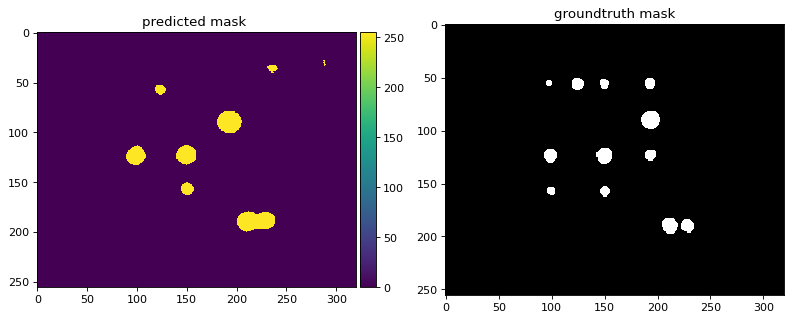

measurement Z_004
results of 2 class classification:
threshold:0.500,
Accuracy:(98.418%),
 Recall:(74.012%),
Precision:(51.793%),
 F score: (60.940%)
iou: (43.823%)



In [41]:

model_folder = '/content/drive/My Drive/PVC-Infrared dataset/working/'
data_folder = data_splitting_folder
measurement_name = 'Z_004'
test_label_path = join(data_folder, measurement_name+'_mask.png')
data_path = join(data_folder, measurement_name+'.mat')
model_path = join(model_folder, 'best_model' + '.pth')



evaluate(measurement_name, test_label_path, data_path, model_path)

<ipython-input-48-732dda8095ab>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location='cpu')


Processing Z_002...


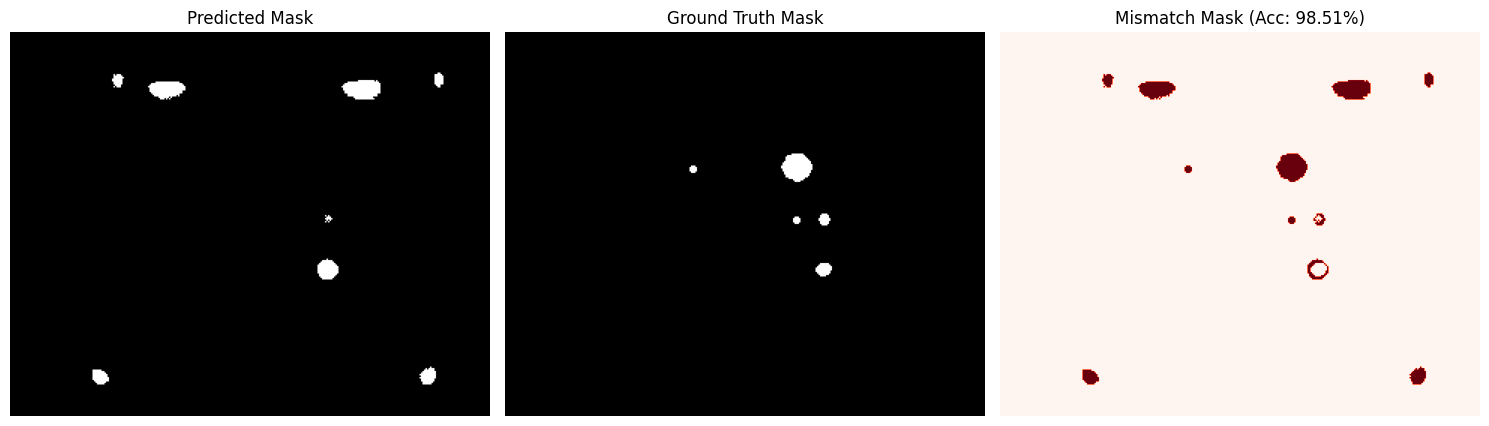

Processing Z_003...


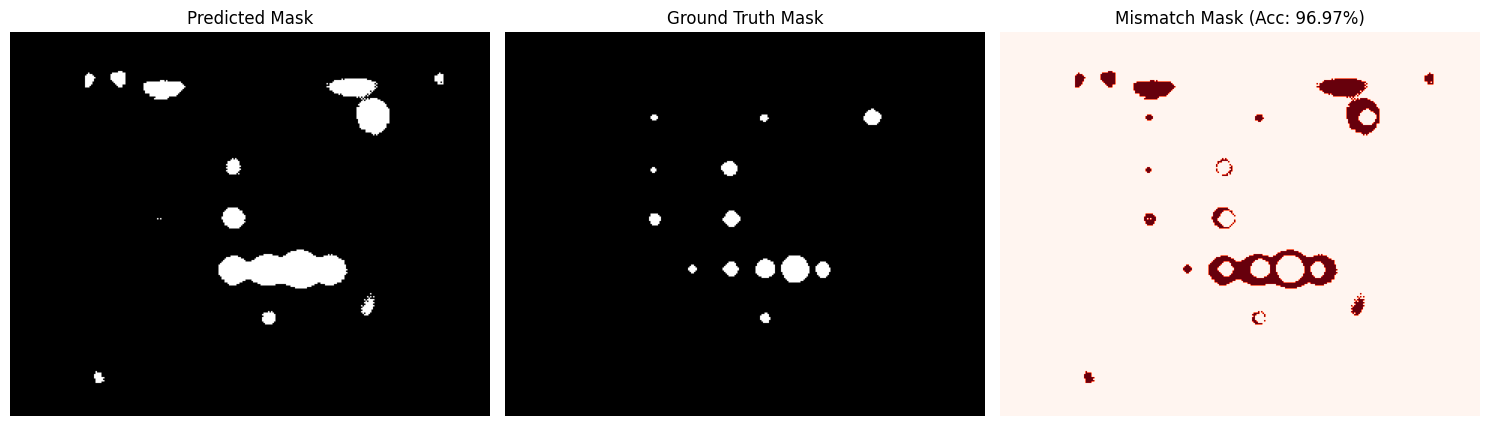

Processing Z_004...


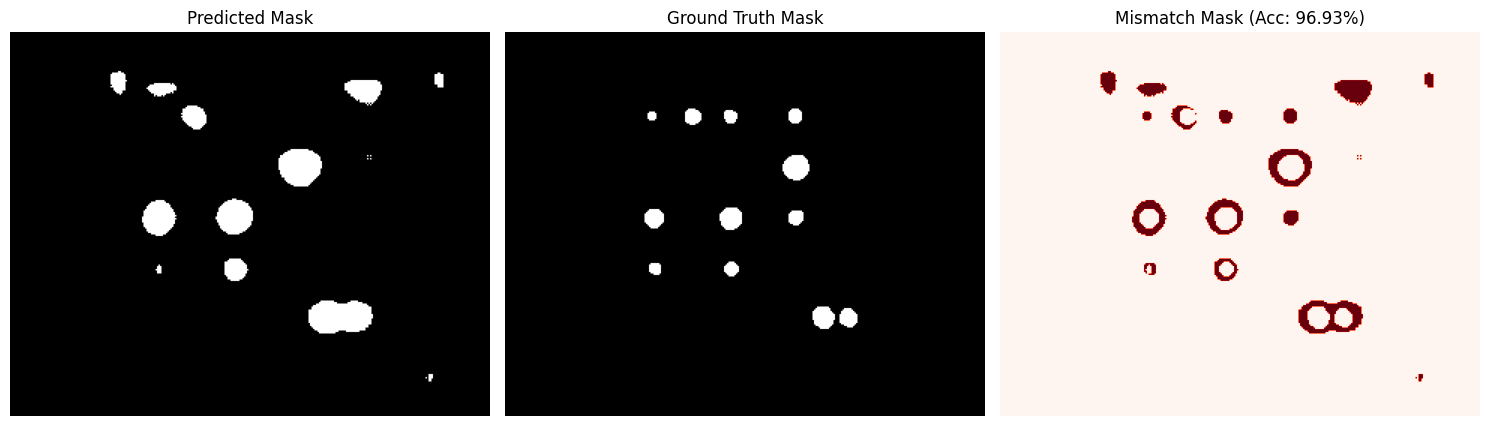

Processing Z_005...


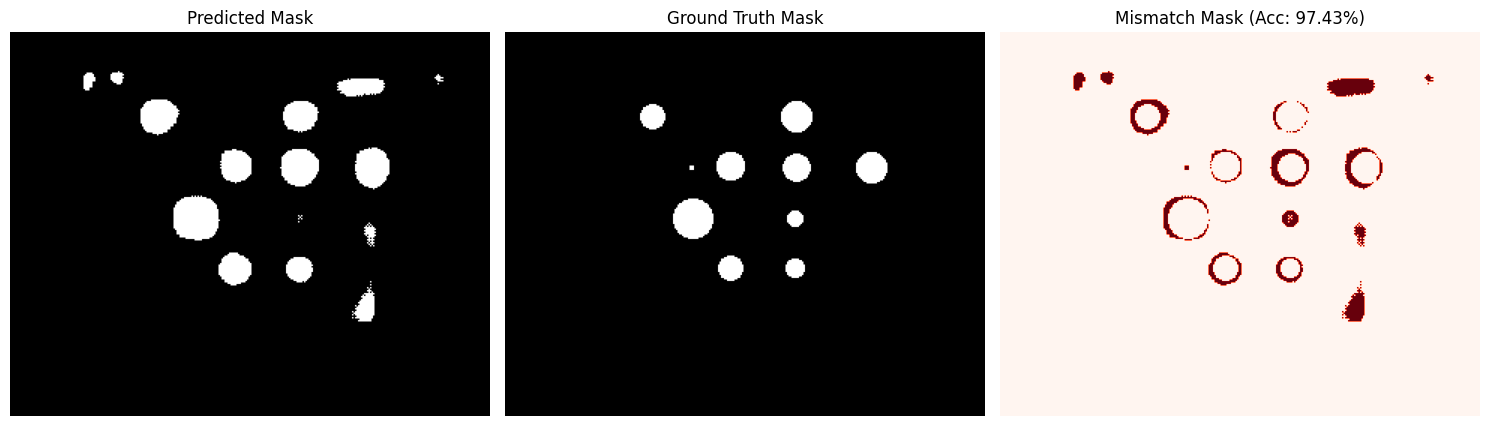

Processing Z_006...


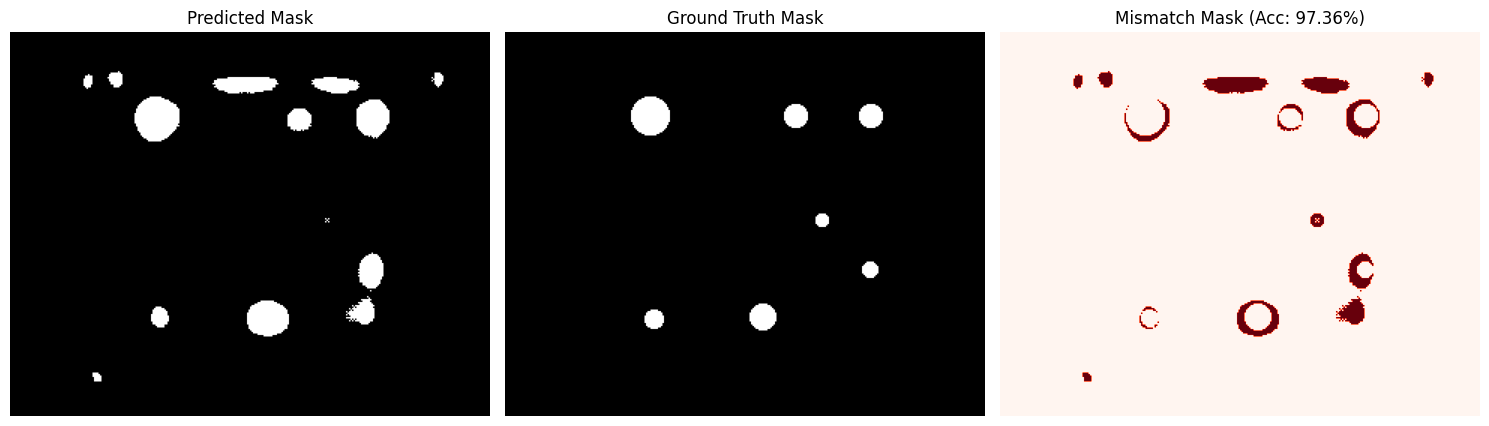

Processing Z_007...


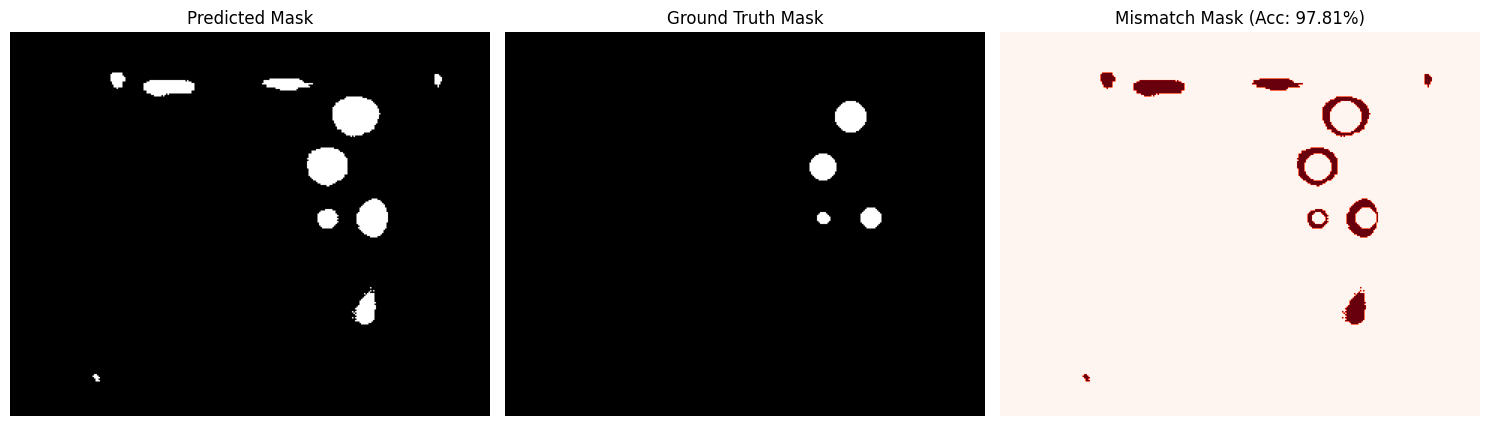

Processing Z_008...


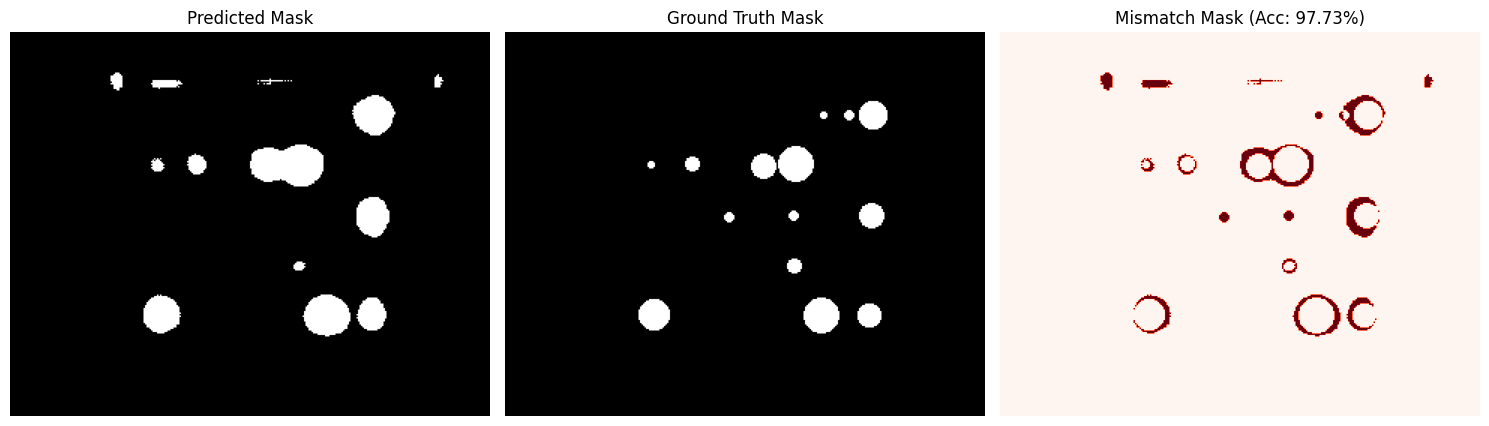

Processing Z_009...


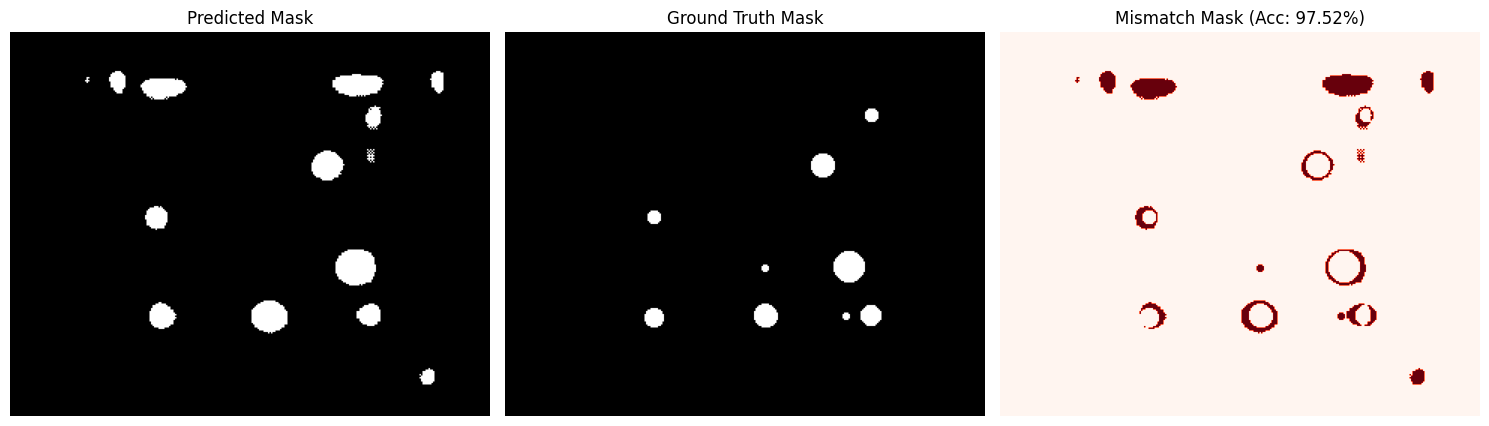

Processing Z_010...


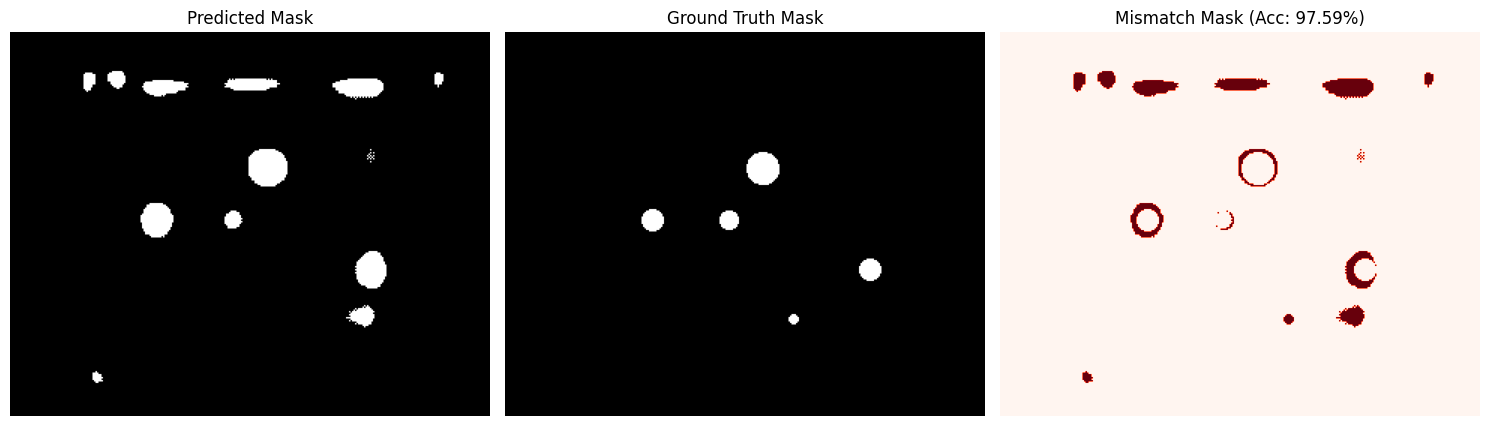

Processing Z_011...


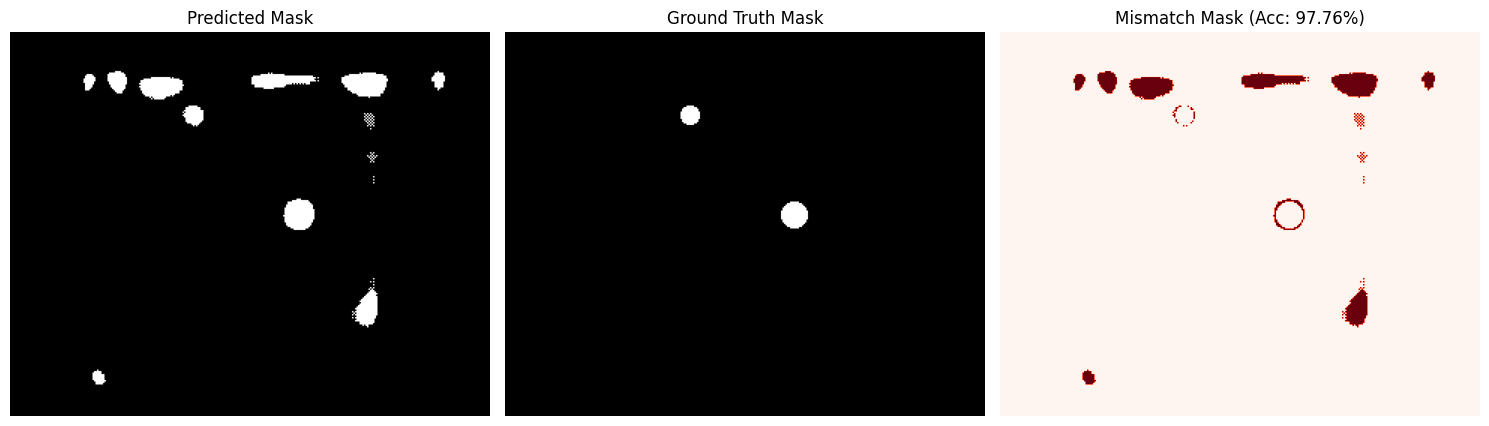

Processing Z_012...


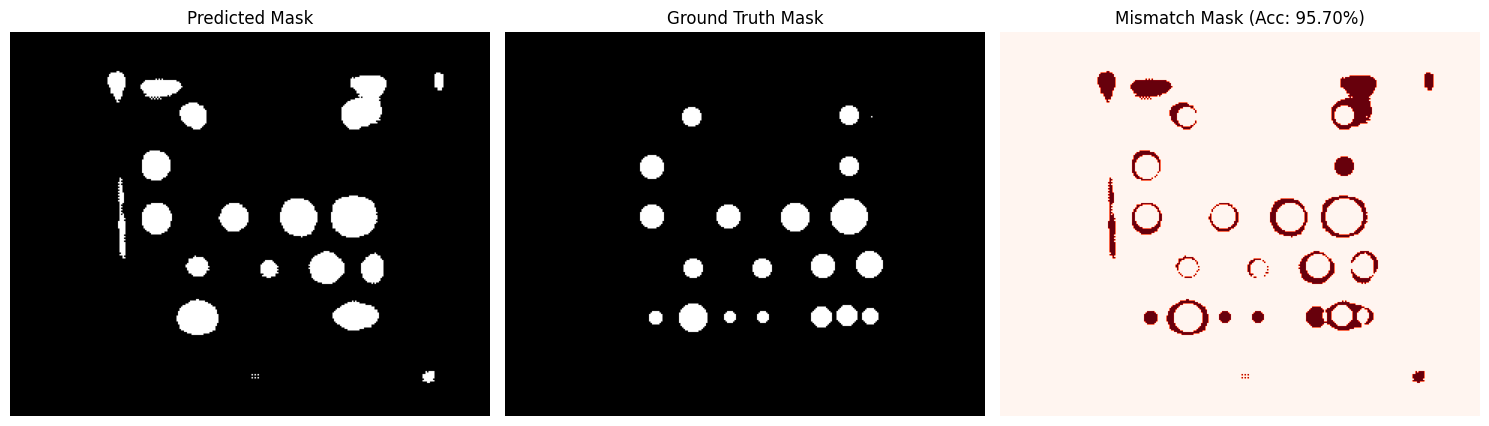

Processing Z_013...


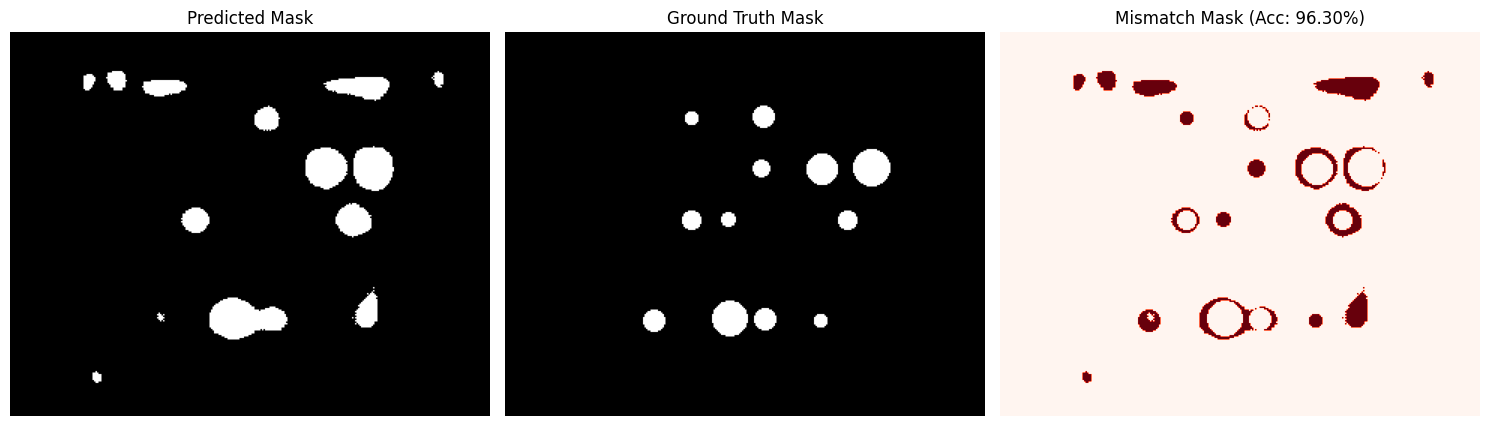

Processing Z_014...


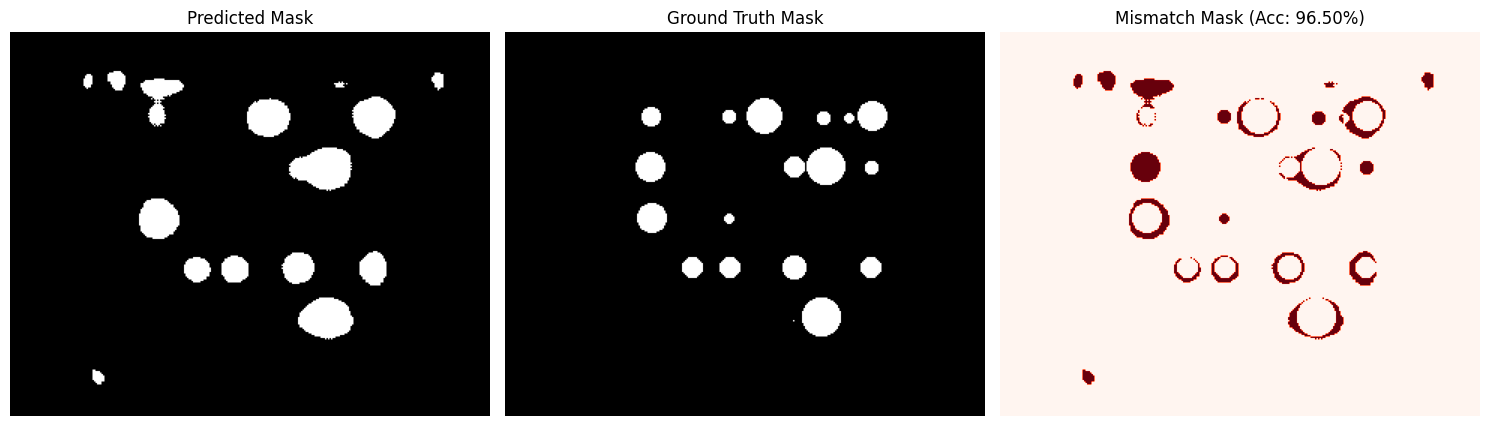

Processing Z_015...


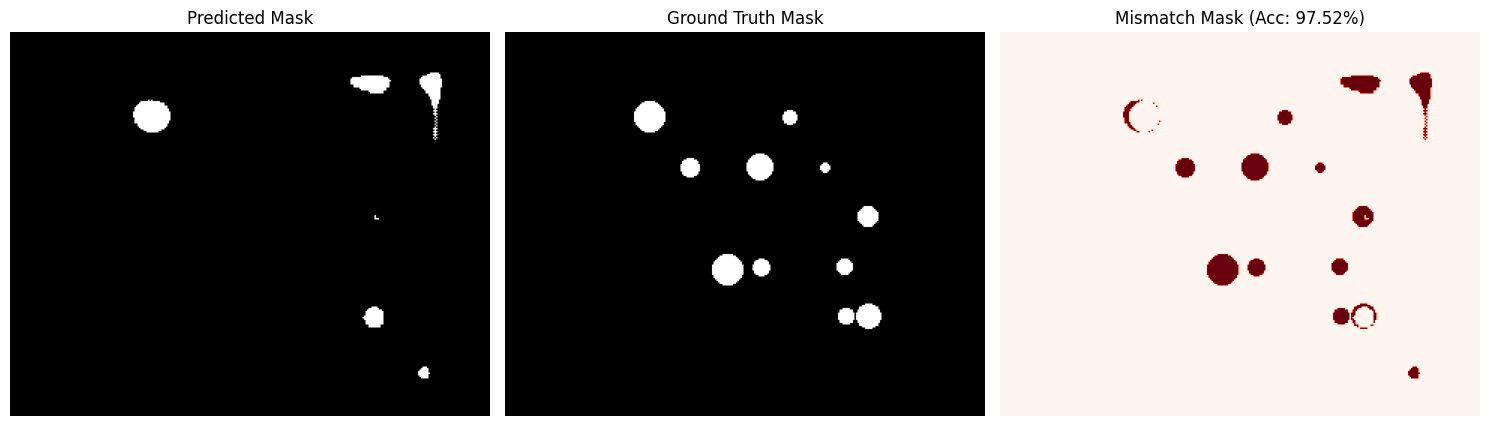

Processing Z_016...


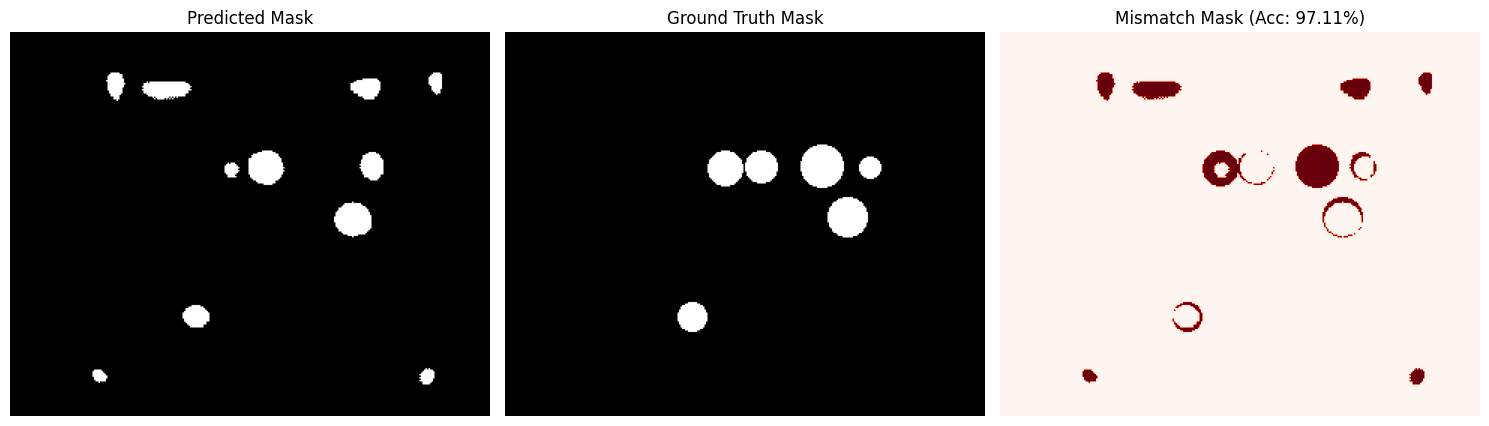

Processing Z_017...


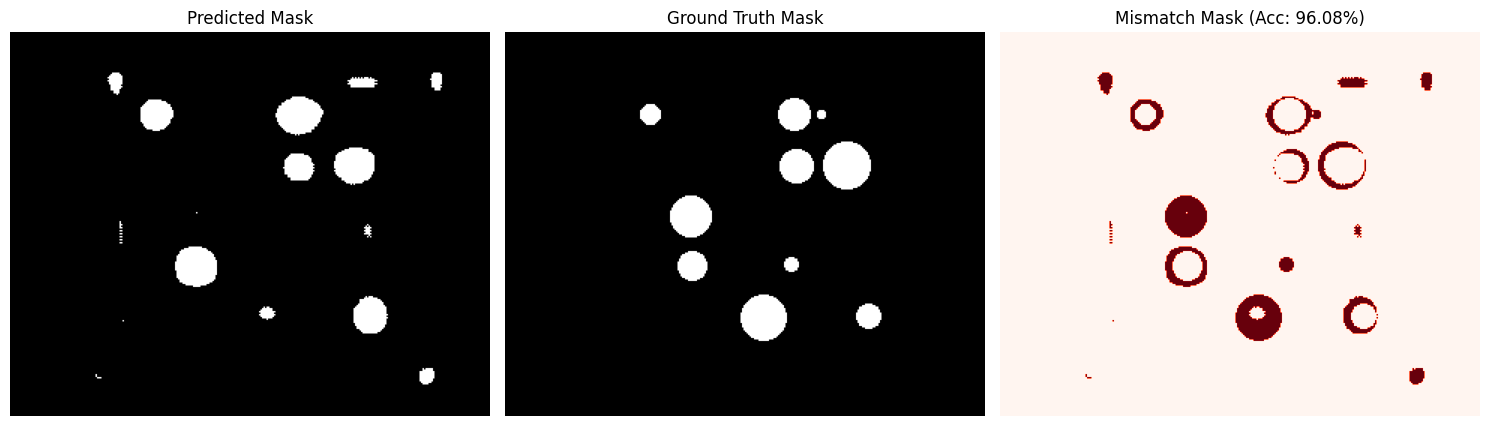

Processing Z_018...


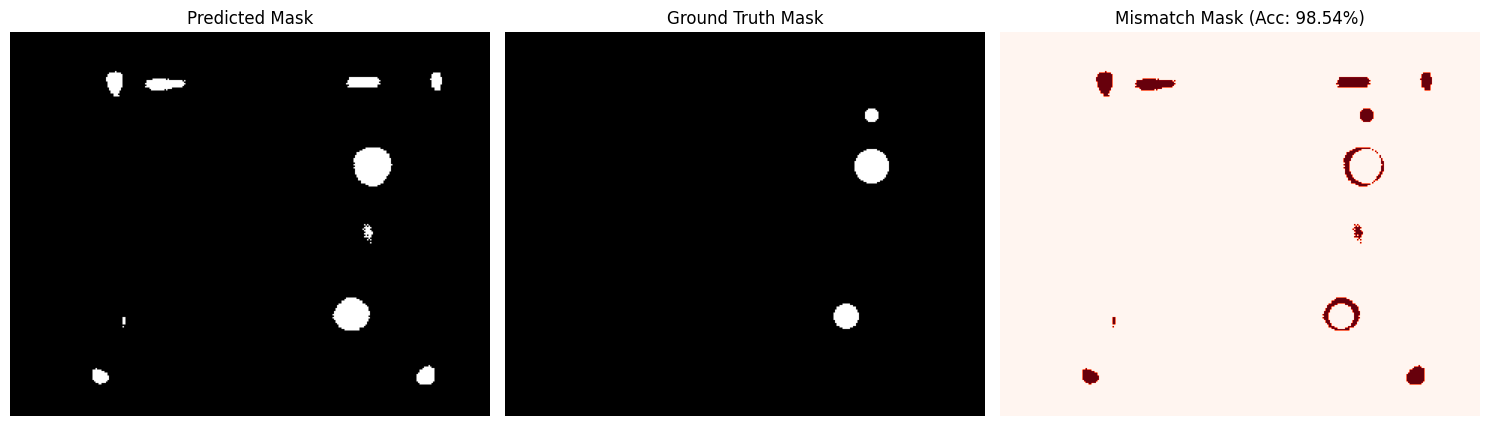

Processing Z_019...


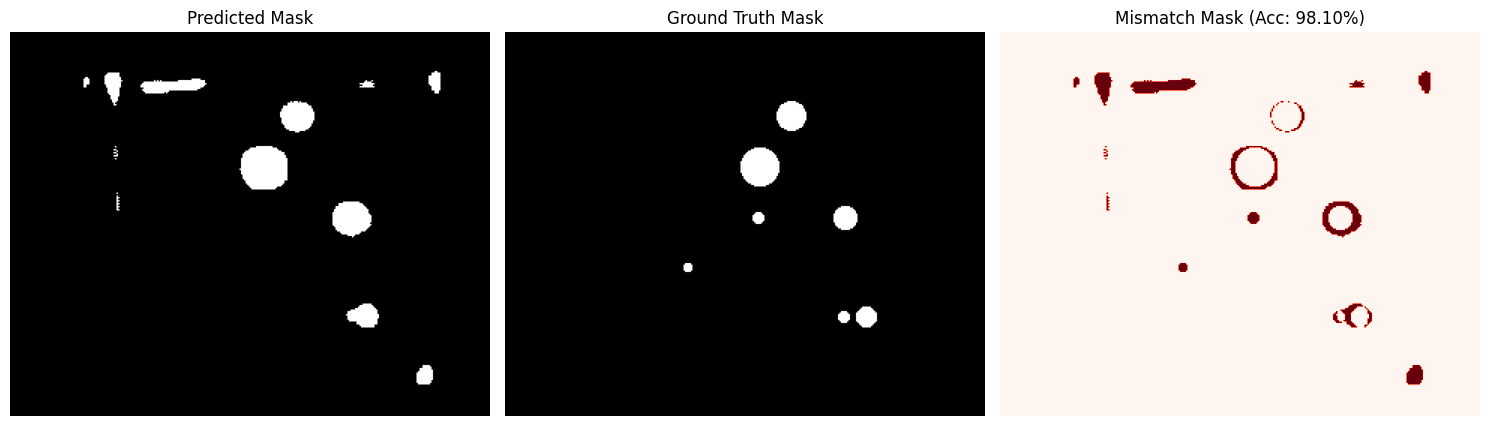

Processing Z_020...


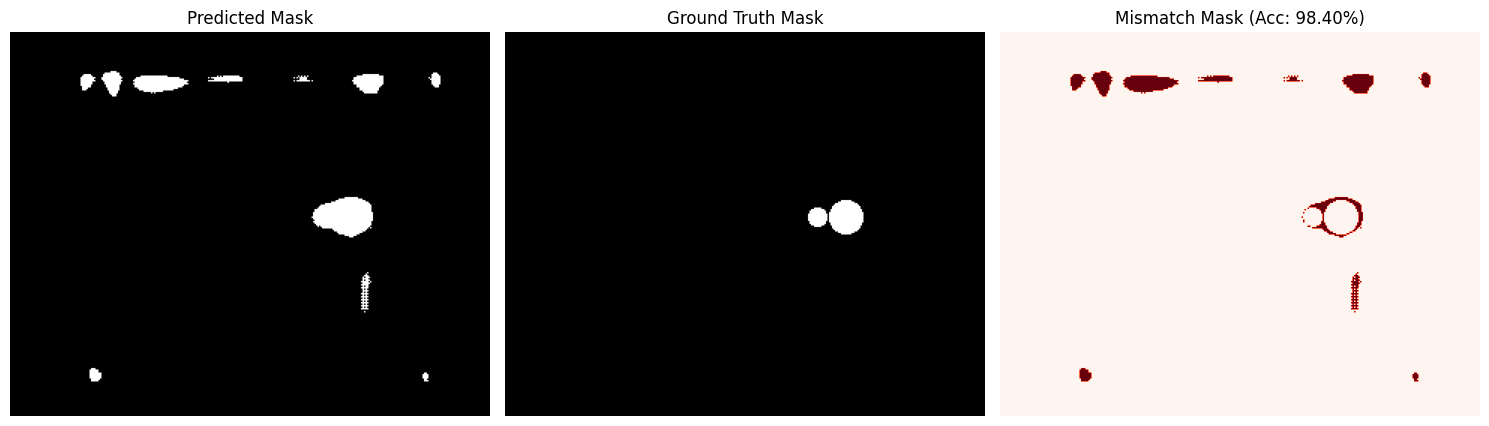

In [48]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image
import skimage.io as im
from sklearn.metrics import accuracy_score

# Directory paths
data_folder = '/content/drive/My Drive/PVC-Infrared dataset/'
model_folder = '/content/drive/My Drive/PVC-Infrared dataset/working/'
model_filename = 'best_model.pth'

# Load the model
model_path = os.path.join(model_folder, model_filename)
model = torch.load(model_path, map_location='cpu')
model.eval()

# Function to process a single .mat file
def process_and_visualize(mat_file, mask_file, model, threshold=0.6):
    # Load .mat file data
    mat_data = loadmat(mat_file)
    data = np.float32(mat_data["imageArray"])  # Key may vary depending on the .mat structure

    # Prepare input tensor
    imge = torch.from_numpy(data.copy()).permute(2, 0, 1)  # Channel first
    input_tensor = torch.zeros(1, imge.size(0), imge.size(1), imge.size(2))
    input_tensor[0] = imge

    # Normalize input
    eps = 1e-10
    mean_value = torch.mean(input_tensor)
    std_value = torch.std(input_tensor)
    input_tensor = (input_tensor - mean_value) / max(eps, std_value)

    # Predict mask
    with torch.no_grad():
        output = model(input_tensor)
    predicted_mask = output.squeeze().numpy()
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Load ground truth mask
    gt_mask = im.imread(mask_file) // 255  # Normalize ground truth to binary (0, 1)

    # Compute mismatch mask
    mismatch_mask = (predicted_mask != gt_mask).astype(np.uint8)

    # Compute accuracy
    accuracy = accuracy_score(gt_mask.flatten(), predicted_mask.flatten()) * 100

    # Display results
    plt.figure(figsize=(15, 5))

    # Predicted mask
    plt.subplot(1, 3, 1)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')

    # Mismatch mask
    plt.subplot(1, 3, 3)
    plt.title(f'Mismatch Mask (Acc: {accuracy:.2f}%)')
    plt.imshow(mismatch_mask, cmap='Reds')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Iterate through all .mat files and display masks
def process_all_files(data_folder, model):
    mat_files = [f for f in os.listdir(data_folder) if f.endswith('.mat')]
    mask_files = {os.path.basename(f).split("_mask")[0]: f for f in os.listdir(data_folder) if f.endswith('_mask.png')}

    for mat_file in mat_files:
        measurement_name = os.path.basename(mat_file).split(".")[0]
        if measurement_name not in mask_files:
            print(f"No mask file found for {measurement_name}, skipping...")
            continue

        mat_path = os.path.join(data_folder, mat_file)
        mask_path = os.path.join(data_folder, mask_files[measurement_name])

        print(f"Processing {measurement_name}...")
        process_and_visualize(mat_path, mask_path, model)

# Process all files
process_all_files(data_folder, model)
